In [1]:
import sys
sys.path.insert(0, "/home/krzysiek/Development/claim-modelling/claim_modelling_kedro/src/")

import logging

logger = logging.getLogger(__name__)
logger.setLevel("INFO")

In [1]:
import os
import mlflow
import logging
import time
import tempfile
from abc import ABC, abstractmethod
from datetime import timedelta
from typing import Any, Dict, Union, List, Tuple

import pandas as pd
import numpy as np


logger = logging.getLogger(__name__)

In [3]:
# !pip install git+https://github.com/krzpiesiewicz/timeseries

In [3]:
from timeseries import Interval, plot_ts
from timeseries.plotting import plot_hist, plot_stats

In [4]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("test")
run = mlflow.start_run(run_name="dev_run")

In [5]:
from claim_modelling_kedro.pipelines.utils.utils import (
    load_metrics_table_from_mlflow,
    load_predictions_and_target_from_mlflow,
    load_metrics_cv_stats_from_mlflow,
    get_partition,
    get_mlflow_run_id_for_partition,
)

In [11]:
# Step 1: Sort the target_df by stratify_target_col in descending order
t = np.hstack((np.arange(101,110,1), np.array([100] * 15 + [50] * 20), np.arange(0, 20, 1)))
t = np.sort(t)[::-1]
t

array([109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,  50,  50,
        50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,
        50,  50,  50,  50,  50,  19,  18,  17,  16,  15,  14,  13,  12,
        11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1,   0])

In [19]:
# Step 2: Label the sorted samples in a round-robin manner
n_samples = t.shape[0]
cv_folds = 5
fold_labels = np.tile(np.arange(cv_folds), n_samples // cv_folds + 1)[:n_samples]

random_seed = 1
rng = np.random.default_rng(random_seed)
for i in range(0, n_samples, cv_folds):
    rng.shuffle(fold_labels[i : min(i + cv_folds, n_samples)])
fold_labels

array([4, 0, 1, 2, 3, 3, 0, 1, 4, 2, 2, 3, 4, 1, 0, 1, 3, 4, 0, 2, 3, 0,
       1, 4, 2, 1, 3, 0, 2, 4, 4, 3, 1, 0, 2, 0, 2, 1, 3, 4, 3, 1, 2, 0,
       4, 2, 0, 3, 4, 1, 1, 3, 2, 4, 0, 3, 4, 1, 0, 2, 0, 3, 2, 1])

In [28]:
np.linspace(0, len(t), cv_folds+1).astype(int)

array([ 0, 12, 25, 38, 51, 64])

In [29]:
t[:-1]

array([109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,  50,  50,
        50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,
        50,  50,  50,  50,  50,  19,  18,  17,  16,  15,  14,  13,  12,
        11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1])

In [14]:
df = pd.DataFrame({"train_score": [1.13332, 2,3.3333333], "valid_score": [4, 5.1, 5454]})
logger.warning(df.to_string())

   train_score  valid_score
0     1.133320          4.0
1     2.000000          5.1
2     3.333333       5454.0


In [15]:
np.std([])

/home/krzysiek/Development/claim-modelling/venv/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/krzysiek/Development/claim-modelling/venv/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/krzysiek/Development/claim-modelling/venv/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [4]:
m = np.mean([1, 2, np.nan])
print(m)
np.isfinite(m)

nan


False

In [16]:
import numpy as np
from sklearn.isotonic import IsotonicRegression

x = np.array([1, 2, 3, 4, 5])
y = np.array([1, 2, 100, 2, 1])  # outlier

iso = IsotonicRegression()
y_hat = iso.fit_transform(x, y)

print(f"Suma y:     {y.sum()}")      # 106
print(f"Suma ŷ_hat: {y_hat.sum()}")  # np. 29.6 — dużo mniejsza


Suma y:     106
Suma ŷ_hat: 106.0


In [17]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([10, 20, 1000, 20, 10])  # mocniejszy outlier

iso = IsotonicRegression()
y_hat = iso.fit_transform(x, y)

print(f"Suma y:     {y.sum()}")       # 1060
print(f"Suma ŷ_hat: {y_hat.sum()}")   # np. 300–500 → mniejsza


Suma y:     1060
Suma ŷ_hat: 1060.0


In [18]:
from sklearn.isotonic import IsotonicRegression
import numpy as np

x = np.array([1, 2, 3, 4, 5])
y = np.array([10, 10, 1000, 10, 10])
w = np.array([1, 1, 0.01, 1, 1])  # mocno ograniczamy wpływ 1000

iso = IsotonicRegression()
y_hat = iso.fit_transform(x, y)

print("Suma y:     ", y.sum())
print("Suma y_hat: ", y_hat.sum())


Suma y:      1040
Suma y_hat:  1040.0


In [21]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([10, 10, 1000, 10, 10])
w = np.array([1000, 1000, 0.0001, 1, 1])  # środkowy punkt praktycznie ignorowany

iso = IsotonicRegression()
y_hat = iso.fit_transform(x, y, sample_weight=w)

print("Suma y:     ", (y * w).sum())
print("Suma y_hat: ", (y_hat * w).sum())


Suma y:      20020.1
Suma y_hat:  20020.100000000002


In [22]:
from sklearn.isotonic import IsotonicRegression
import numpy as np

x = np.array([1, 2, 3, 4, 5])
y = np.array([10, 10, 1000, 10, 10])
w = np.array([1000, 1000, 0.0001, 1, 1])

iso = IsotonicRegression()
y_hat = iso.fit_transform(x, y, sample_weight=w)

# Sprawdźmy total balance po ważeniu
print("Suma(y * w):", np.sum(y * w))
print("Suma(ŷ * w):", np.sum(y_hat * w))


Suma(y * w): 20020.1
Suma(ŷ * w): 20020.100000000002


In [6]:
# mlflow_run_id = "9e92594a898c403481fc72fbcbeeeeb0"
mlflow_run_id = "47e637d039ad460ea311b1aa8f1b207e"

In [8]:
!ls ../data/04_sample/selected_features

ls: nie ma dostępu do '../data/04_sample/selected_features': Nie ma takiego pliku ani katalogu


In [72]:
sample_features_df = pd.read_parquet("../data/04_sample/selected_features")

In [74]:
sample_features_df.loc[4139495,:]

feature
VehGas_Regular           1.0
Area_C                   0.0
DrivAgeCategory_51_70    0.0
Area_D                   0.0
DrivAgeCategory_41_50    0.0
Area_E                   0.0
VehBrand_B2              0.0
VehBrand_B1              0.0
DrivAgeCategory_31_40    0.0
VehBrand_B12             0.0
Region_Centre            0.0
Name: 4139495, dtype: float64

In [7]:
mlflow.artifacts.list_artifacts(run_id=mlflow_run_id, artifact_path="predictions/test")

[<FileInfo: file_size=None, is_dir=True, path='predictions/test/prediction'>,
 <FileInfo: file_size=None, is_dir=True, path='predictions/test/target'>]

In [8]:
mlflow.artifacts.list_artifacts(run_id=mlflow_run_id, artifact_path="sample_features")

[]

In [9]:
mlflow.artifacts.list_artifacts(run_id=mlflow_run_id, artifact_path="predictions/sample")

[]

In [52]:
sample_predictions_df, sample_target_df = load_predictions_and_target_from_mlflow(dataset="sample", mlflow_run_id=mlflow_run_id)

In [62]:
df = pd.concat([sample_predictions_df["0"], sample_target_df["0"]], axis=1)
df

,ClaimSeverity_PRED,ClaimNb_TRG,ClaimFreq_TRG,ClaimSeverity_TRG,ClaimTotalAmount_TRG,ClaimPurePremium_TRG,Exposure
IDpol,,,,,,,
2203080,1560.233910,1,2.631579,4672.000,4672.00,12294.736842,0.38
3072051,1143.944719,1,1.000000,3774.490,3774.49,3774.490000,1.00
4134571,1867.989157,1,1.000000,3204.000,3204.00,3204.000000,1.00
2226840,1228.957116,1,3.030303,1558.010,1558.01,4721.242424,0.33
73380,1973.458548,2,10.526316,994.545,1989.09,10468.894737,0.19
...,...,...,...,...,...,...,...
2231031,1228.957116,1,12.500000,1000.550,1000.55,12506.875000,0.08
2255909,1289.432925,1,2.040816,757.820,757.82,1546.571429,0.49
5088642,-58948.979010,1,1.886792,95.680,95.68,180.528302,0.53


In [63]:
df.sort_values(by="ClaimSeverity_PRED")

,ClaimSeverity_PRED,ClaimNb_TRG,ClaimFreq_TRG,ClaimSeverity_TRG,ClaimTotalAmount_TRG,ClaimPurePremium_TRG,Exposure
IDpol,,,,,,,
4139495,-58948.979010,1,1.204819,1544.46,1544.46,1860.795181,0.83
2185505,-58948.979010,1,1.000000,260.02,260.02,260.020000,1.00
2129756,-58948.979010,1,7.142857,1172.00,1172.00,8371.428571,0.14
4153362,-58948.979010,1,1.000000,1204.00,1204.00,1204.000000,1.00
5089924,-58948.979010,1,1.190476,1320.00,1320.00,1571.428571,0.84
...,...,...,...,...,...,...,...
2147506,94807.397360,1,2.439024,1172.00,1172.00,2858.536585,0.41
4117020,94807.397360,1,1.250000,1204.00,1204.00,1505.000000,0.80
3084368,94807.397360,1,1.000000,938.40,938.40,938.400000,1.00


In [12]:
sample_target_df["0"].describe()

,ClaimNb_TRG,ClaimFreq_TRG,ClaimSeverity_TRG,ClaimTotalAmount_TRG,ClaimPurePremium_TRG,Exposure
count,8000.000000,8000.000000,8.000000e+03,8.000000e+03,8.000000e+03,8000.000000
mean,1.059125,3.054171,2.546672e+03,2.678630e+03,1.135828e+04,0.696339
std,0.251271,8.545768,4.643319e+04,4.649261e+04,2.390180e+05,0.312292
min,1.000000,1.000000,1.820000e+00,1.820000e+00,2.426667e+00,0.002740
25%,1.000000,1.000000,7.032000e+02,7.498375e+02,1.128000e+03,0.450000
50%,1.000000,1.351351,1.172000e+03,1.172000e+03,1.504160e+03,0.780000
75%,1.000000,2.380952,1.214130e+03,1.352670e+03,3.299698e+03,1.000000
max,4.000000,365.000000,4.075401e+06,4.075401e+06,1.852455e+07,1.000000


In [10]:
calib_predictions_df, calib_target_df = load_predictions_and_target_from_mlflow(dataset="calib", mlflow_run_id=mlflow_run_id)

In [20]:
calib_target_df["0"].ClaimSeverity_TRG.sort_values()[-20:]

IDpol
3056959     20345.81
2064176     20602.99
89541       20927.43
4172127     26356.45
1083202     26575.01
2211584     26672.00
4163678     31204.00
148193      34819.25
1098349     35326.79
4186822     39660.00
78656       41614.72
1024506     44927.41
3186271     55152.45
4037514     61469.00
2081784     67986.88
43832       96422.32
1017853    121959.21
3150210    281897.49
3075820    287423.00
110846     702092.76
Name: ClaimSeverity_TRG, dtype: float64

In [34]:
calib_predictions_df["0"].describe()

,pure_ClaimSeverity_PRED,calibrated_ClaimSeverity_PRED,ClaimSeverity_PRED
count,2494.000000,2.494000e+03,2.494000e+03
mean,2804.594335,7.464446e+04,7.464446e+04
std,6411.074132,5.372112e+05,5.372112e+05
min,1.820000,8.021372e+01,8.021372e+01
25%,1311.371144,3.209802e+03,3.209802e+03
50%,1725.874001,4.406378e+03,4.406378e+03
75%,2369.259669,5.799162e+03,5.799162e+03
max,94807.397360,4.178491e+06,4.178491e+06


In [10]:
test_predictions_df, test_target_df = load_predictions_and_target_from_mlflow(dataset="test", mlflow_run_id=mlflow_run_id)

In [11]:
test_predictions_df["0"].head()

,pure_ClaimSeverity_PRED,calibrated_ClaimSeverity_PRED,ClaimSeverity_PRED
IDpol,,,
3206481,1524.007211,1707.188939,1707.188939
1181933,1785.832358,2714.828361,2714.828361
1123439,1962.808800,2714.828361,2714.828361
6102278,2106.214044,3188.180000,3188.180000
3086829,2128.578390,8172.867143,8172.867143


In [12]:
test_predictions_df["0"].ClaimSeverity_PRED.sort_values()

IDpol
71641      1297.414918
175955     1297.414918
1092862    1297.414918
2260730    1297.414918
3235114    1297.414918
              ...     
2047708    8172.867143
3157170    8172.867143
1035988    8172.867143
3162990    8172.867143
1104337    8172.867143
Name: ClaimSeverity_PRED, Length: 2494, dtype: float64

In [13]:
test_predictions_df["0"].ClaimSeverity_PRED.value_counts().sort_index()

ClaimSeverity_PRED
1297.414918      52
1630.441053      36
1707.188939     321
1780.196316     300
2049.094457     109
2714.828361    1619
3188.180000      22
8172.867143      35
Name: count, dtype: int64

In [138]:
sample_predictions_df["0"].head()

,ClaimSeverity_PRED
IDpol,
2203080,1560.233910
3072051,1143.944719
4134571,1867.989157
2226840,1228.957116
73380,1973.458548


In [139]:
sample_predictions_df["0"].ClaimSeverity_PRED.sort_values()

IDpol
4139495    -58948.979010
2185505    -58948.979010
2129756    -58948.979010
4153362    -58948.979010
5089924    -58948.979010
               ...      
2147506     94807.397360
4117020     94807.397360
3084368     94807.397360
2200889    189136.482294
3043774    189136.482294
Name: ClaimSeverity_PRED, Length: 8000, dtype: float64

In [53]:
a = sample_predictions_df["0"].ClaimSeverity_PRED.sort_values()
a[a <= 0]

IDpol
1123011   -368697.184872
3057395   -368697.184872
177371    -117198.423022
4166204    -23012.709369
3047899    -23012.709369
3112717    -23012.709369
Name: ClaimSeverity_PRED, dtype: float64

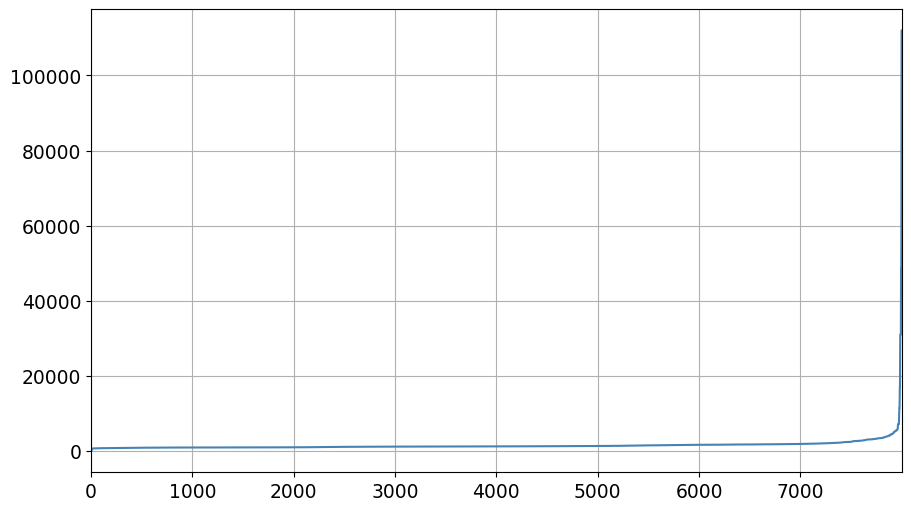

In [46]:
plot_ts(sample_predictions_df["0"].ClaimSeverity_PRED.sort_values().values)

In [54]:
sample_predictions_df["0"].ClaimSeverity_PRED.sum()

11889694.029622028

In [48]:
sample_target_df["0"].ClaimSeverity_TRG.sum()

10576220.395

In [55]:
(sample_predictions_df["0"].ClaimSeverity_PRED.sum() - sample_target_df["0"].ClaimSeverity_TRG.sum()) / sample_target_df["0"].ClaimSeverity_TRG.sum()

0.12419121250943146

In [62]:
calib_predictions_df["0"].head()

,pure_ClaimSeverity_PRED,calibrated_ClaimSeverity_PRED,ClaimSeverity_PRED
IDpol,,,
1120377,1350.106961,2498.224465,2498.224465
3075820,1308.265684,2498.224465,2498.224465
4169019,1507.873773,2498.224465,2498.224465
1096763,1351.624392,2498.224465,2498.224465
2206511,1211.852058,2498.224465,2498.224465


In [70]:
calib_target_df["0"].head()

,ClaimNb_TRG,ClaimFreq_TRG,ClaimSeverity_TRG,ClaimTotalAmount_TRG,ClaimPurePremium_TRG,Exposure
IDpol,,,,,,
1120377,1,4.545455,4075400.56,4075400.56,1.852455e+07,0.22
3075820,1,1.724138,287423.00,287423.00,4.955569e+05,0.58
4169019,1,7.692308,276643.00,276643.00,2.128023e+06,0.13
1096763,1,1.000000,255013.03,255013.03,2.550130e+05,1.00
2206511,1,2.380952,241171.16,241171.16,5.742170e+05,0.42


In [72]:
combined_df = pd.concat([calib_predictions_df["0"][["pure_ClaimSeverity_PRED"]], calib_target_df["0"][["ClaimSeverity_TRG"]]], axis=1)

In [73]:
combined_df

,pure_ClaimSeverity_PRED,ClaimSeverity_TRG
IDpol,,
1120377,1350.106961,4075400.56
3075820,1308.265684,287423.00
4169019,1507.873773,276643.00
1096763,1351.624392,255013.03
2206511,1211.852058,241171.16
...,...,...
3174485,1452.653255,3.29
2188088,1241.146502,2.00
3191712,1209.885078,1.59


In [75]:
sorted_df = combined_df.sort_values(by="pure_ClaimSeverity_PRED", ascending=True)

In [76]:
sorted_df

,pure_ClaimSeverity_PRED,ClaimSeverity_TRG
IDpol,,
2055918,1174.293208,1172.00
2100595,1174.293208,1785.83
2188189,1174.293208,5808.85
160052,1174.293208,233.62
1159231,1174.620075,524.00
...,...,...
4154625,1755.475468,1204.00
2177585,1762.886945,1172.00
1131878,1803.156217,1128.00


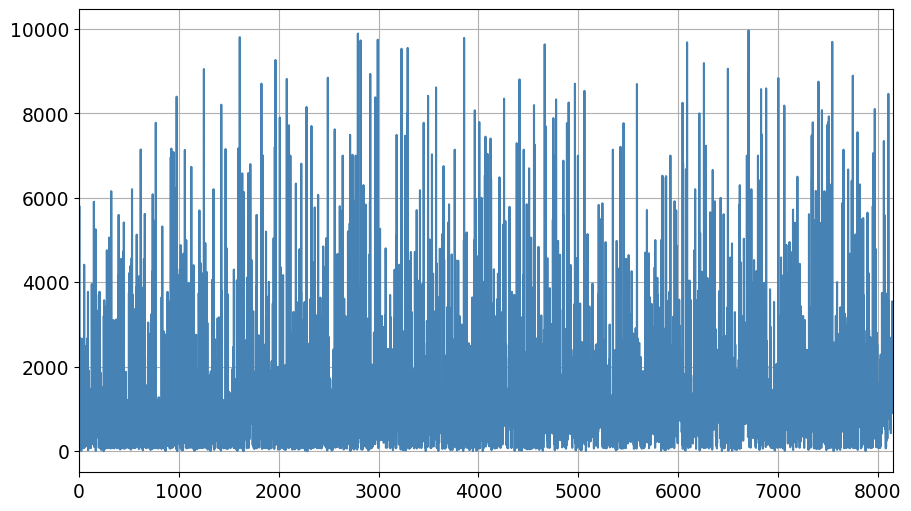

In [79]:
plot_ts(sorted_df.ClaimSeverity_TRG.values[sorted_df.ClaimSeverity_TRG.values < 10000])

In [63]:
calib_predictions_df["0"].ClaimSeverity_PRED.sum()

20765241.754166663

In [69]:
calib_predictions_df["0"].pure_ClaimSeverity_PRED.sum()

10991037.697088534

In [64]:
calib_target_df["0"].ClaimSeverity_TRG.sum()

20765241.754166663

In [68]:
calib_predictions_df["0"].ClaimSeverity_PRED.sort_values()

IDpol
1120377    2498.224465
1159323    2498.224465
2081887    2498.224465
2087868    2498.224465
1197871    2498.224465
              ...     
3189107    2498.224465
4159836    2498.224465
3182210    2498.224465
4159168    2498.224465
1031713    2498.224465
Name: ClaimSeverity_PRED, Length: 8312, dtype: float64

In [65]:
calib_predictions_df["0"].pure_ClaimSeverity_PRED.sort_values()

IDpol
2055918    1174.293208
2100595    1174.293208
2188189    1174.293208
160052     1174.293208
1159231    1174.620075
              ...     
4154625    1755.475468
2177585    1762.886945
1131878    1803.156217
2075585    1812.040549
1088305    1855.335619
Name: pure_ClaimSeverity_PRED, Length: 8312, dtype: float64

In [10]:
predictions_df

{'0':          pure_ClaimFreq_PRED  calibrated_ClaimFreq_PRED  ClaimFreq_PRED
 IDpol                                                                  
 4169479             0.084812                   0.118505        0.118505
 1029561             0.063508                   0.117399        0.117399
 6101794             0.178691                   0.123507        0.123507
 4120268             0.189139                   0.124076        0.124076
 76230               0.495778                   0.142012        0.142012
 ...                      ...                        ...             ...
 2069846             0.143597                   0.121613        0.121613
 2069826             0.137237                   0.121273        0.121273
 2069827             0.234025                   0.126553        0.126553
 2069892             0.166104                   0.122824        0.122824
 2069907             0.121476                   0.120434        0.120434
 
 [67801 rows x 3 columns],
 '1':          pu

In [26]:
mlflow.artifacts.list_artifacts(run_id=mlflow_run_id, artifact_path="results/test")

[<FileInfo: file_size=2611, is_dir=False, path='results/test/pure_test_metrics_by_part.csv'>,
 <FileInfo: file_size=684, is_dir=False, path='results/test/pure_test_metrics_cv_stats.csv'>,
 <FileInfo: file_size=2590, is_dir=False, path='results/test/test_metrics_by_part.csv'>,
 <FileInfo: file_size=632, is_dir=False, path='results/test/test_metrics_cv_stats.csv'>]

In [37]:
def load_pd_dataframe_csv_from_mlflow(artifact_path: str, filename: str = None,mlflow_run_id: str = None, index_col=None,
                                      columns_index_name=None) -> pd.DataFrame:
    if mlflow_run_id is None:
        mlflow_run_id = mlflow.active_run().info.run_id
    with tempfile.TemporaryDirectory() as temp_dir:
        artifact_path = f"{artifact_path}/{filename}" if filename is not None else artifact_path
        artifact_uri = f"runs:/{mlflow_run_id}/{artifact_path}"
        local_path = mlflow.tracking.artifact_utils._download_artifact_from_uri(artifact_uri, temp_dir)
        df = pd.read_csv(local_path, index_col=index_col)
        df.columns.name = columns_index_name
        return df

In [38]:
def _file_name(dataset: str, prefix: str = None, suffix: str = None, ext: str = None) -> str:
    filename = f"{prefix}_{dataset}" if prefix is not None else dataset
    filename = f"{filename}_{suffix}" if suffix is not None else filename
    return f"{filename}.{ext}" if ext is not None else filename


def get_metrics_table_filname_and_artifact_path(dataset: str, prefix: str = None) -> Tuple[str, str]:
    filename = _file_name(dataset, prefix, "metrics_by_part", "csv")
    artifact_path = f"results/{dataset}"
    return filename, artifact_path


def save_metrics_table_in_mlflow(metrics_df: pd.DataFrame, dataset: str, prefix: str = None):
    csv_filename, artifact_path = get_metrics_table_filname_and_artifact_path(dataset, prefix)
    save_pd_dataframe_as_csv_in_mlflow(metrics_df, artifact_path=artifact_path, csv_filename=csv_filename)


def load_metrics_table_from_mlflow(dataset: str, prefix: str = None, mlflow_run_id: str = None) -> pd.DataFrame:
    filename, artifact_path = get_metrics_table_filname_and_artifact_path(dataset, prefix)
    metrics_df = load_pd_dataframe_csv_from_mlflow(artifact_path, filename, mlflow_run_id, index_col="metric",
                                                   columns_index_name="part")
    return metrics_df

In [41]:
def get_metrics_cv_stats_filname_and_artifact_path(dataset: str, prefix: str = None) -> Tuple[str, str]:
    filename = _file_name(dataset, prefix, "metrics_cv_stats", "csv")
    artifact_path = f"results/{dataset}"
    return filename, artifact_path


def load_metrics_cv_stats_from_mlflow(dataset: str, prefix: str = None, mlflow_run_id: str = None) -> pd.DataFrame:
    filename, artifact_path = get_metrics_cv_stats_filname_and_artifact_path(dataset, prefix)
    metrics_cv_stats_df = load_pd_dataframe_csv_from_mlflow(artifact_path, filename, mlflow_run_id, index_col="metric")
    return metrics_cv_stats_df

In [42]:
metrics_cv_stats = load_metrics_cv_stats_from_mlflow(dataset="test", mlflow_run_id = mlflow_run_id)

In [43]:
metrics_by_part = load_metrics_table_from_mlflow(dataset="test", mlflow_run_id = mlflow_run_id)

In [44]:
metrics_by_part

part,0,1,2,3,4,5,6,7,8,9
metric,,,,,,,,,,
test_MPD,0.885846,1.052887,1.027052,0.944465,1.111153,0.825786,0.929565,1.133675,0.961578,1.134429
test_wMPD,0.505019,0.502245,0.489405,0.494871,0.484315,0.488367,0.500906,0.494655,0.497689,0.491305
test_RMSE,1.513411,2.012962,2.210971,1.782154,2.090518,1.157011,2.081918,2.446309,1.874213,2.471737
test_wRMSE,0.475220,0.497380,0.490774,0.474673,0.507172,0.460856,0.478562,0.513426,0.475881,0.522860
test_R2,-0.000013,-0.000033,0.000057,-0.000039,-0.000118,0.000160,-0.000037,0.000024,0.000135,-0.000001
test_wR2,-0.009950,-0.008303,-0.005438,-0.012563,-0.003927,-0.005484,-0.012740,-0.006914,-0.012645,-0.004112
test_MBD,-0.013600,0.003708,0.007861,-0.015178,0.021936,-0.005455,-0.018451,0.014418,-0.014462,0.018672
test_wMBD,-0.048384,-0.044381,-0.038422,-0.054090,-0.032194,-0.035958,-0.053802,-0.040086,-0.053971,-0.035364
test_SC,0.026622,0.022289,0.028210,0.023575,0.019243,0.023648,0.024641,0.023222,0.027876,0.026632


In [132]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# # Example dataset
# X = pd.DataFrame({"x1": [0, 1, 2, 3, 4]})
# y = pd.Series([1e6, 1e3, 2e3, 1e7, 1])  # Positive target values (Gamma distributed)
# Example dataset
X = pd.DataFrame({"x1": [1, 2, 3, 4]})
y = pd.Series([1e3, 1e5, 1e6, 1e3])
# X = pd.DataFrame({"x1": [1, 2, 3]})
# y = pd.Series([1e3, 1e5, 1e6])

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit a Gamma GLM with an Inverse link
model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.InversePower()))
results = model.fit(tol=1e-16, method="newton")

# Print the model summary
print(results.summary())

# Check predictions
predictions = results.predict(X)
print("Predictions:", predictions)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                    4
Model:                            GLM   Df Residuals:                        2
Model Family:                   Gamma   Df Model:                            1
Link Function:           InversePower   Scale:                          3.0733
Method:                        newton   Log-Likelihood:                -58.266
Date:                Sat, 28 Dec 2024   Deviance:                       75.650
Time:                        23:19:41   Pearson chi2:                     6.15
No. Iterations:                     6   Pseudo R-squ. (CS):             -78.46
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.963e-05   9.02e-05      0.994      0.3

/home/krzysiek/Development/claim-modelling/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [127]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# # Example dataset
# X = pd.DataFrame({"x1": [0, 1, 2, 3, 4]})
# y = pd.Series([1e6, 1e3, 2e3, 1e7, 1])  # Positive target values (Gamma distributed)
# Example dataset
X = pd.DataFrame({"x1": [1, 2, 3, 4]})
y = pd.Series([1e3, 1e5, 1e6, 1e3])
# X = pd.DataFrame({"x1": [1, 2, 3]})
# y = pd.Series([1e3, 1e5, 1e6])

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit a Gamma GLM with an Inverse link
model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.Log()))
results = model.fit()

# Print the model summary
print(results.summary())

# Check predictions
predictions = results.predict(X)
print("Predictions:", predictions)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                    4
Model:                            GLM   Df Residuals:                        2
Model Family:                   Gamma   Df Model:                            1
Link Function:                    Log   Scale:                          1.7795
Method:                          IRLS   Log-Likelihood:                -49.530
Date:                Sat, 28 Dec 2024   Deviance:                       17.810
Time:                        23:15:04   Pearson chi2:                     3.56
No. Iterations:                    70   Pseudo R-squ. (CS):             0.4388
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7961      1.634      4.160      0.0

In [147]:
z = [-2, -1, 0.5, 0., 0.5, 1, 2]
power = 1.2
np.power(z, 1. / power) 

/tmp/ipykernel_9496/4249915722.py:3: RuntimeWarning: invalid value encountered in power
  np.power(z, 1. / power)


array([       nan,        nan, 0.56123102, 0.        , 0.56123102,
       1.        , 1.78179744])

### Lorentz curve

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_lorentz_curve(y_true, y_pred, sample_weight=None):
    """
    Calculate the points for the Lorentz curve based on true and predicted values, considering observation weights.

    Args:
        y_true (np.ndarray or pd.Series): True values.
        y_pred (np.ndarray or pd.Series): Predicted values.
        sample_weight (np.ndarray or pd.Series, optional): Weights for observations. Defaults to equal weights.

    Returns:
        tuple: (x_points, y_points) for the weighted Lorentz curve.
    """
    # Convert inputs to numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Initialize equal weights if not provided
    if sample_weight is None:
        sample_weight = np.ones_like(y_true)
    else:
        sample_weight = np.asarray(sample_weight)

    # Combine true values, predicted values, and weights into a single array
    data = np.c_[y_true, y_pred, sample_weight]

    # Sort by predicted values in ascending order (to construct cumulative distribution)
    data_sorted = data[np.argsort(data[:, 1])]

    # Weighted cumulative sum of true values
    weighted_true = data_sorted[:, 0] * data_sorted[:, 2]  # y_true * sample_weight
    cumulative_weighted_true = np.cumsum(weighted_true)

    # Total weighted true value
    total_weighted_true = np.sum(weighted_true)

    # Weighted cumulative count of observations
    cumulative_weighted_count = np.cumsum(data_sorted[:, 2])
    total_weighted_count = np.sum(data_sorted[:, 2])

    # Calculate Lorentz curve points
    x_points = np.insert(cumulative_weighted_count / total_weighted_count, 0, 0)  # Proportion of total weighted observations
    y_points = np.insert(cumulative_weighted_true / total_weighted_true, 0, 0)  # Proportion of total weighted true values

    return x_points, y_points


In [30]:
def plot_lorentz_curve(x_points, y_points, title="Lorentz Curve", marker="o"):
    """
    Plot the Lorentz curve given its points.

    Args:
        x_points (np.ndarray): X-coordinates of the Lorentz curve.
        y_points (np.ndarray): Y-coordinates of the Lorentz curve.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(x_points, y_points, label="Lorentz Curve", color="blue", marker=marker)
    plt.plot([0, 1], [0, 1], label="Line of Equality", linestyle="--", color="gray")
    plt.fill_between(x_points, y_points, y2=x_points, color="blue", alpha=0.1)
    plt.xlabel("Cumulative Proportion of Observations")
    plt.ylabel("Cumulative Proportion of True Values")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


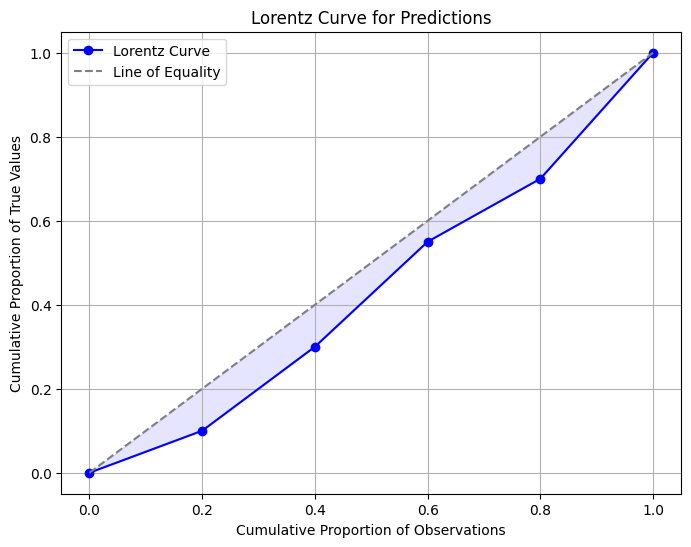

In [31]:
# Example data
y_true = np.array([3, 2, 6, 4, 5])
y_pred = np.array([0.8, 0.4, 0.9, 0.6, 0.7])

# Calculate Lorentz curve points
x_points, y_points = calculate_lorentz_curve(y_true, y_pred)

# Plot the Lorentz curve
plot_lorentz_curve(x_points, y_points, title="Lorentz Curve for Predictions")


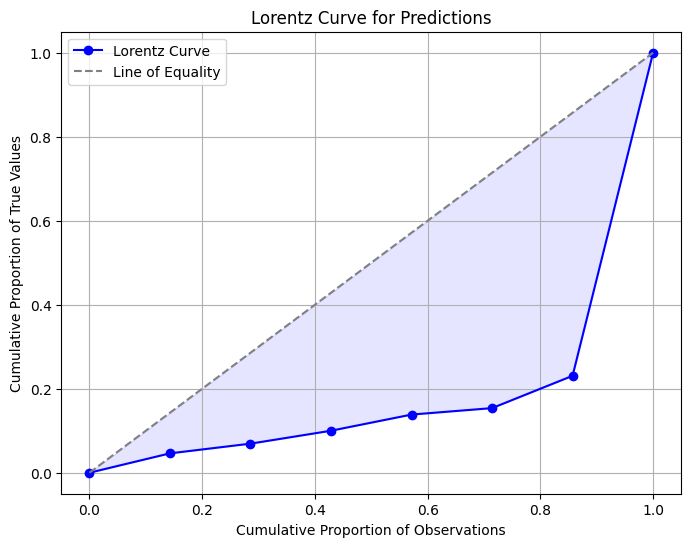

In [34]:
# Example data
y_true = np.array([6, 3, 5, 4, 2, 10, 100])
y_pred = np.array([2, 3, 5, 4, 6, 10, 100])

# Calculate Lorentz curve points
x_points, y_points = calculate_lorentz_curve(y_true, y_pred)

# Plot the Lorentz curve
plot_lorentz_curve(x_points, y_points, title="Lorentz Curve for Predictions")


Explanation
calculate_lorentz_curve:

    Input:
        y_true: Array of true values.
        y_pred: Array of predicted values.
    Output:
        x_points: Cumulative proportion of observations (ranging from 0 to 1).
        y_points: Cumulative proportion of true values corresponding to the sorted predictions.

plot_lorentz_curve:

    Plots the Lorentz curve as a line.
    Includes the Line of Equality (y=xy=x) for reference, which represents perfect equality.
    The shaded area between the Lorentz curve and the Line of Equality indicates inequality or prediction deviation.

This implementation helps you visualize and analyze how well predictions align with true values in terms of cumulative performance.

In [20]:
mlflow.artifacts.list_artifacts(run_id=mlflow_run_id, artifact_path="results/test")

[<FileInfo: file_size=797, is_dir=False, path='results/test/pure_test_metrics_by_part.csv'>,
 <FileInfo: file_size=687, is_dir=False, path='results/test/test_metrics_by_part.csv'>]

In [21]:
metrics_by_part = load_metrics_table_from_mlflow(dataset="test", mlflow_run_id = mlflow_run_id)

In [22]:
test_predictions_df, test_target_df = load_predictions_and_target_from_mlflow(dataset="test", mlflow_run_id=mlflow_run_id)

In [23]:
test_predictions_df['0'].head()

,pure_ClaimSeverity_PRED,calibrated_ClaimSeverity_PRED,ClaimSeverity_PRED
IDpol,,,
3206481,1524.007211,1707.188939,1707.188939
1181933,1785.832358,2714.828361,2714.828361
1123439,1962.808800,2714.828361,2714.828361
6102278,2106.214044,3188.180000,3188.180000
3086829,2128.578390,8172.867143,8172.867143


In [24]:
test_target_df['0'].head()

,ClaimNb_TRG,ClaimFreq_TRG,ClaimSeverity_TRG,ClaimTotalAmount_TRG,ClaimPurePremium_TRG,Exposure
IDpol,,,,,,
3206481,1,1.052632,1204.00,1204.00,1267.368421,0.95
1181933,1,2.325581,1072.26,1072.26,2493.627907,0.43
1123439,1,1.234568,2619.17,2619.17,3233.543210,0.81
6102278,2,3.278689,997.14,1994.28,3269.311475,0.61
3086829,1,1.428571,1204.00,1204.00,1720.000000,0.70


In [82]:
for part in test_target_df.keys():
    print(f"{part=}")
    s = test_target_df[part].ClaimSeverity_TRG.sum()
    print(f"{s=}")
    x = test_target_df[part].ClaimSeverity_TRG[test_target_df[part].ClaimSeverity_TRG > s * 0.01].sort_values()
    print(x)
    print("\n")

part='0'
s=6576743.9350000005
IDpol
2208742      70000.00
125903       71791.29
3234374      75000.00
3097066      78104.83
3025890     191477.57
3122016     774411.50
2141337    1301172.60
Name: ClaimSeverity_TRG, dtype: float64




In [85]:
x = test_target_df['0'].ClaimSeverity_TRG.sort_values()
while len(x) > 0 and x.iloc[-1] > 0.1 * x.sum():
    x = x.iloc[:-1]
print(len(x))
x

2492


IDpol
175914          1.49
1024103         4.52
2064616         6.73
3124260        10.99
1144866        12.19
             ...    
2208742     70000.00
125903      71791.29
3234374     75000.00
3097066     78104.83
3025890    191477.57
Name: ClaimSeverity_TRG, Length: 2492, dtype: float64

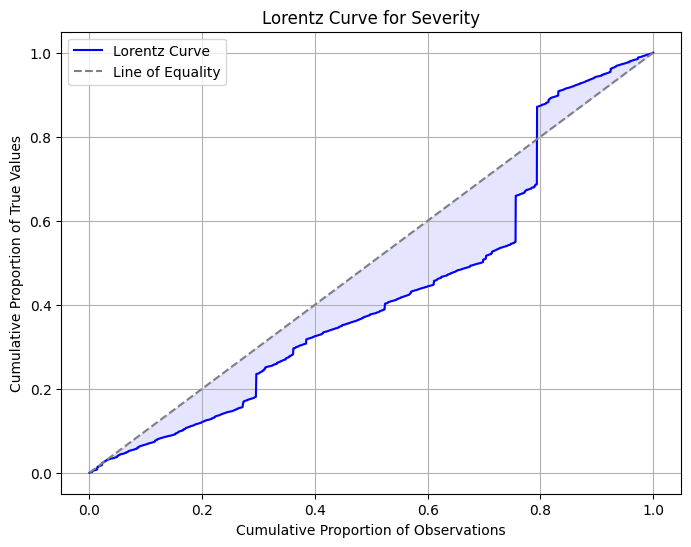

In [32]:
x_points, y_points = calculate_lorentz_curve(y_true = test_target_df['0'].ClaimSeverity_TRG, y_pred = test_predictions_df["0"].pure_ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG)
plot_lorentz_curve(x_points, y_points, title="Lorentz Curve for Severity", marker=None)

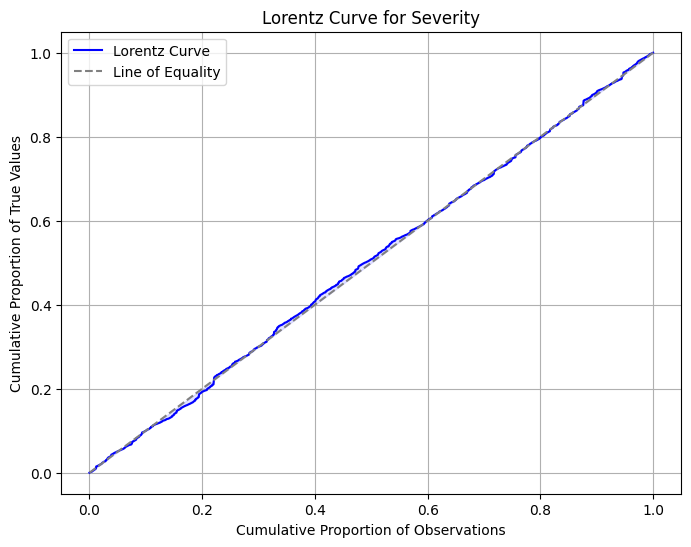

In [33]:
index = test_target_df['0'].ClaimSeverity_TRG < 37622
x_points, y_points = calculate_lorentz_curve(y_true = test_target_df['0'][index].ClaimSeverity_TRG, y_pred = test_predictions_df['0'][index].ClaimSeverity_PRED, sample_weight=test_target_df['0'][index].ClaimNb_TRG)
plot_lorentz_curve(x_points, y_points, title="Lorentz Curve for Severity", marker=None)

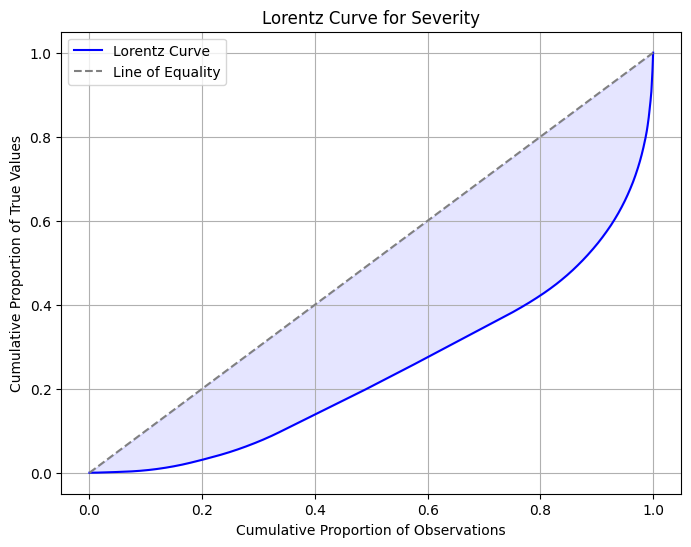

In [34]:
index = test_target_df['0'].ClaimSeverity_TRG < 74784
x_points, y_points = calculate_lorentz_curve(y_true = test_target_df['0'][index].ClaimSeverity_TRG, y_pred = test_target_df['0'][index].ClaimSeverity_TRG, sample_weight=test_target_df['0'][index].ClaimNb_TRG)
plot_lorentz_curve(x_points, y_points, title="Lorentz Curve for Severity", marker=None)

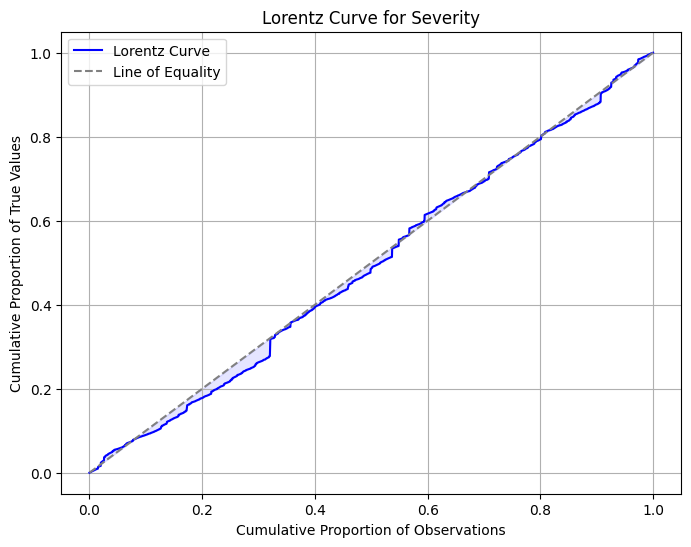

In [82]:
sv = test_target_df['0'].ClaimSeverity_TRG.copy()
sv[sv > 100000] = 100000
x_points, y_points = calculate_lorentz_curve(y_true = sv, y_pred = test_predictions_df['0'].ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG)
plot_lorentz_curve(x_points, y_points, title="Lorentz Curve for Severity", marker=None)

## Cumulative Percentile Statistics

In [14]:
import pandas as pd
import numpy as np

def cumulative_percentile_statistics(
    y_true: pd.Series,
    y_pred: pd.Series,
    sample_weight: pd.Series = None,
    percentiles: list = None,
    task_name: str = "Metric",
    ascending: bool = True,
):
    """
    Calculate cumulative statistics across percentiles for weighted predictions and actual values.

    Args:
        y_true (pd.Series): Actual target values (severity, frequency, or pure premium).
        y_pred (pd.Series): Predicted target values.
        sample_weight (pd.Series, optional): Observation weights. Defaults to equal weight.
        percentiles (list, optional): List of percentiles to calculate. Defaults to [10, 20, ..., 99].
        task_name (str): Name of the task (e.g., "Severity", "Frequency").

    Returns:
        pd.DataFrame: Cumulative statistics across percentiles with Cumulative Lift.
    """
    if percentiles is None:
        percentiles = list(range(10, 100, 10)) + [99]

    # Initialize equal weights if none are provided
    if sample_weight is None:
        sample_weight = pd.Series(np.ones_like(y_true), index=y_true.index)

    # Combine inputs into a single DataFrame
    data = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'weight': sample_weight
    })

    # Sort by predicted values (descending)
    data_sorted = data.sort_values(by='y_pred', ascending=ascending).reset_index(drop=True)

    # Calculate the total weighted true response
    total_weighted_true = np.sum(data_sorted['y_true'] * data_sorted['weight'])

    results = []

    for perc in sorted(percentiles, reverse = not ascending):
        if ascending:
            cutoff = int(np.ceil(len(data_sorted) * ((perc + 1) / 100)))
        else:
            cutoff = int(np.ceil(len(data_sorted) * ((100 - perc) / 100)))
        subset = data_sorted.iloc[:cutoff]

        # Weighted sums and averages
        weighted_sum = np.sum(subset['weight'])
        weighted_pred_avg = np.average(subset['y_pred'], weights=subset['weight'])
        weighted_true_avg = np.average(subset['y_true'], weights=subset['weight'])

        # Cumulative captured response
        cum_captured_response = np.sum(subset['y_true'] * subset['weight']) / total_weighted_true

        # Cumulative lift calculation
        if ascending:
            expected_response = (perc + 1) / 100
        else:
            expected_response = (100 - perc) / 100  # Expected response under random selection
        cum_lift = cum_captured_response / expected_response if expected_response > 0 else np.nan

        results.append({
            'Percentile': f'{perc}',
            'Number of Observations': weighted_sum,
            f'Weighted Predicted Avg {task_name}': weighted_pred_avg,
            f'Weighted True Avg {task_name}': weighted_true_avg,
            'Cumulative Captured Response': cum_captured_response,
            'Cumulative Lift': cum_lift
        })

    # Convert results to DataFrame
    stats_df = pd.DataFrame(results)

    return stats_df


In [60]:
percentiles = list(range(0, 10)) + list(range(10, 90, 10)) + list(range(90, 100))

In [64]:
df = cumulative_percentile_statistics(y_true=test_target_df['0'].ClaimSeverity_TRG, y_pred = test_predictions_df["0"].ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG, percentiles = percentiles, task_name="Severity",
                                     ascending=True)
df

,Percentile,Number of Observations,Weighted Predicted Avg Severity,Weighted True Avg Severity,Cumulative Captured Response,Cumulative Lift
0,0,26,1297.414918,1306.781923,0.004819,0.481901
1,1,52,1297.414918,1555.015385,0.011469,0.573442
2,2,78,1399.884498,2636.680769,0.029170,0.972328
3,3,104,1467.117122,2335.963750,0.034457,0.861432
4,4,132,1518.041447,2145.935000,0.040177,0.803530
5,5,158,1549.166984,1963.124367,0.043993,0.733222
6,6,185,1572.229648,1948.319297,0.051123,0.730324
7,7,211,1588.859703,1893.910000,0.056679,0.708490
8,8,237,1601.840969,1801.123165,0.060544,0.672715
9,9,264,1612.615193,1712.303712,0.064116,0.641160


In [67]:
df = cumulative_percentile_statistics(y_true=test_target_df['0'].ClaimSeverity_TRG, y_pred = test_predictions_df["0"].ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG, percentiles = percentiles, task_name="Severity",
                                     ascending=False)
df

,Percentile,Number of Observations,Weighted Predicted Avg Severity,Weighted True Avg Severity,Cumulative Captured Response,Cumulative Lift
0,99,25,8172.867143,1291.708800,0.004580,0.458022
1,98,53,6479.954528,1186.597547,0.008920,0.445996
2,97,81,5225.180213,1206.588642,0.013862,0.462067
3,96,107,4615.188174,1407.569346,0.021362,0.534042
4,95,132,4255.271543,1376.511061,0.025771,0.515425
5,94,161,3977.800411,1489.990248,0.034024,0.567074
6,93,187,3802.200019,1527.123636,0.040504,0.578628
7,92,212,3673.972229,1446.671509,0.043500,0.543748
8,91,237,3572.796716,1640.498608,0.055145,0.612722
9,90,266,3479.258812,1630.821090,0.061528,0.615276


## Concentration Curve

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_concentration_curve(y_true, exposure, sample_weight=None):
    """
    Calculate the points for the Concentration Curve.

    Args:
        y_true (pd.Series or np.ndarray): Actual loss amounts (claims).
        exposure (pd.Series or np.ndarray): Exposure or premium values.
        sample_weight (pd.Series or np.ndarray, optional): Observation weights. Defaults to None.

    Returns:
        tuple: (x_points, y_points) for the Concentration Curve.
    """
    # Convert inputs to numpy arrays
    y_true = np.asarray(y_true)
    exposure = np.asarray(exposure)
    
    # Apply sample weights if provided
    if sample_weight is None:
        sample_weight = np.ones_like(y_true)
    else:
        sample_weight = np.asarray(sample_weight)

    # Combine true losses, exposure, and weights
    data = np.c_[y_true, exposure, sample_weight]

    # Sort by exposure in descending order
    data_sorted = data[np.argsort(-data[:, 1])]

    # Weighted cumulative sums
    weighted_losses = data_sorted[:, 0] * data_sorted[:, 2]
    weighted_exposure = data_sorted[:, 1] * data_sorted[:, 2]

    # Total sums for normalization
    total_losses = weighted_losses.sum()
    total_exposure = weighted_exposure.sum()

    # Cumulative sums
    cum_losses = np.cumsum(weighted_losses) / total_losses
    cum_exposure = np.cumsum(weighted_exposure) / total_exposure

    # Include the origin point (0, 0)
    cum_losses = np.insert(cum_losses, 0, 0)
    cum_exposure = np.insert(cum_exposure, 0, 0)

    return cum_exposure, cum_losses


def plot_concentration_curve(x_points, y_points, title="Concentration Curve", marker="o"):
    """
    Plot the Concentration Curve.

    Args:
        x_points (np.ndarray): Cumulative proportion of exposure or premium.
        y_points (np.ndarray): Cumulative proportion of actual losses.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(x_points, y_points, label="Concentration Curve", color="green", marker=marker)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Line of Equality")
    plt.fill_between(x_points, y_points, x_points, color="green", alpha=0.1)
    plt.xlabel("Cumulative Proportion of predicted severity")
    plt.ylabel("Cumulative Proportion of claims sizes")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


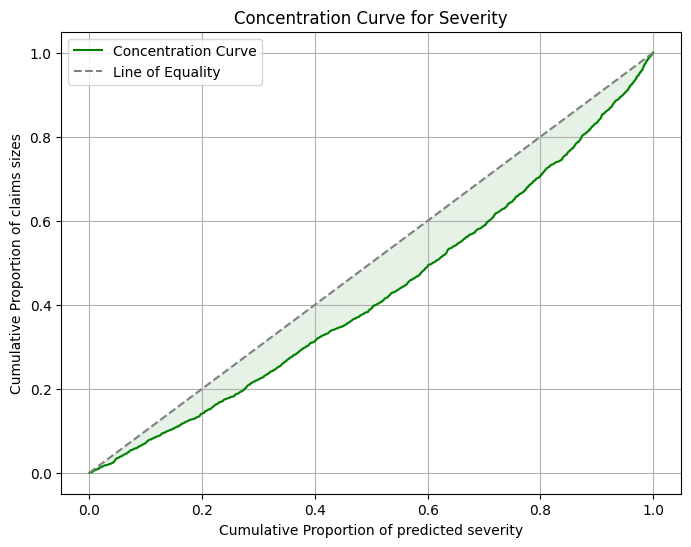

In [16]:
# Example data
np.random.seed(42)
n_samples = 1000

# Simulate actual losses and exposure (or premiums)
y_true_losses = pd.Series(np.random.gamma(shape=2.0, scale=1000.0, size=n_samples))
exposure = pd.Series(np.random.uniform(500, 1500, size=n_samples))

# Optional sample weights
weights = pd.Series(np.random.uniform(0.5, 1.5, size=n_samples))

# Calculate concentration curve points
x_concentration, y_concentration = calculate_concentration_curve(y_true_losses, exposure, sample_weight=weights)

# Plot the concentration curve
plot_concentration_curve(x_concentration, y_concentration, title="Concentration Curve for Severity", marker=None)


In [18]:
test_target_df['0'].ClaimSeverity_TRG.sort_values().tail(25)

IDpol
100135       16510.220
49189        17319.760
1077761      19056.130
76662        19883.770
1181678      20000.000
4020812      21255.540
1013313      21408.725
2268680      22343.050
4122619      22600.000
2274545      24441.660
2270955      26653.540
4159364      27204.000
2261431      40000.000
76323        40000.000
4164838      41204.000
1040527      43963.580
2088184      50880.000
4181821      51204.000
2208742      70000.000
125903       71791.290
3234374      75000.000
3097066      78104.830
3025890     191477.570
3122016     774411.500
2141337    1301172.600
Name: ClaimSeverity_TRG, dtype: float64

In [20]:
test_target_df['0'].ClaimSeverity_TRG.sort_values().tail(25)  / test_target_df['0'].ClaimSeverity_TRG.sum()

IDpol
100135     0.002510
49189      0.002633
1077761    0.002898
76662      0.003023
1181678    0.003041
4020812    0.003232
1013313    0.003255
2268680    0.003397
4122619    0.003436
2274545    0.003716
2270955    0.004053
4159364    0.004136
2261431    0.006082
76323      0.006082
4164838    0.006265
1040527    0.006685
2088184    0.007736
4181821    0.007786
2208742    0.010644
125903     0.010916
3234374    0.011404
3097066    0.011876
3025890    0.029114
3122016    0.117750
2141337    0.197844
Name: ClaimSeverity_TRG, dtype: float64

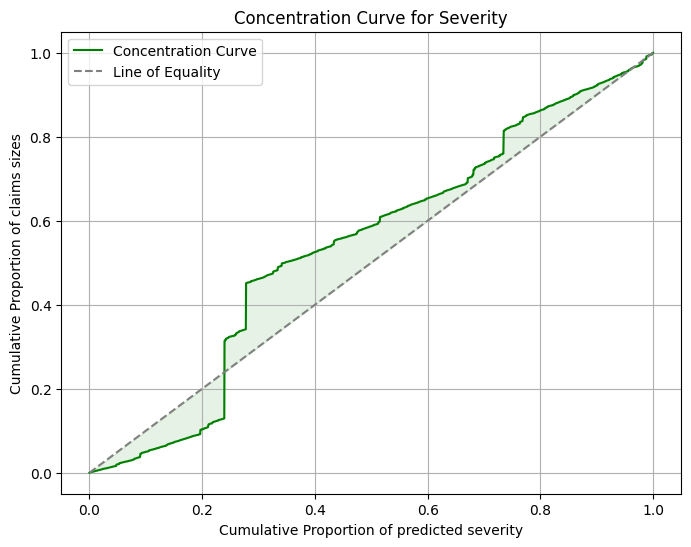

In [40]:
x_concentration, y_concentration = calculate_concentration_curve(y_true=test_target_df['0'].ClaimSeverity_TRG, exposure = test_predictions_df["0"].pure_ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG,)

# Plot the concentration curve
plot_concentration_curve(x_concentration, y_concentration, title="Concentration Curve for Severity", marker=None)

In [25]:
sv.tail() / sv.sum()

IDpol
3234374    0.016270
3097066    0.016944
3025890    0.021693
3122016    0.021693
2141337    0.021693
Name: ClaimSeverity_TRG, dtype: float64

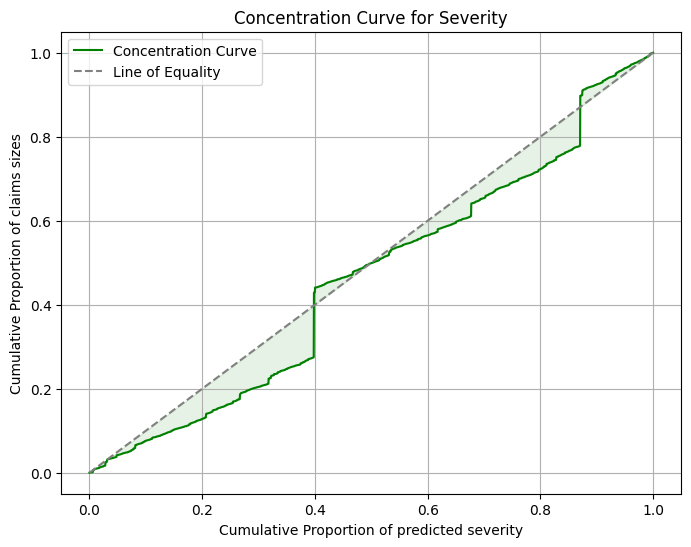

In [77]:
sv = test_target_df['0'].ClaimSeverity_TRG.sort_values().copy()
sv[sv > 1000000] = 1000000
x_concentration, y_concentration = calculate_concentration_curve(y_true=sv, exposure = test_predictions_df["0"].pure_ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG,)

# Plot the concentration curve
plot_concentration_curve(x_concentration, y_concentration, title="Concentration Curve for Severity", marker=None)

In [19]:
np.quantile(test_target_df['0'].ClaimSeverity_TRG.sort_values().quantile

IDpol
175914      1.49
1024103     4.52
2064616     6.73
3124260    10.99
1144866    12.19
3152826    12.47
4168651    12.54
2094286    15.00
126659     15.08
42766      16.56
2192235    22.05
2208380    23.09
98802      23.92
2089424    25.80
3127519    28.30
4154661    29.80
4144127    30.30
1154363    31.00
1048465    33.65
2202612    33.86
46620      35.92
1079445    36.75
36906      37.12
3139104    37.18
2057361    38.34
Name: ClaimSeverity_TRG, dtype: float64

In [71]:
test_target_df['0'].ClaimSeverity_TRG.sort_values().iloc[-50:-25]

IDpol
2074426     9548.36
3148163     9642.54
4140142     9756.50
2282277    10000.00
3247175    10000.00
2078498    10000.00
3253481    10000.00
4132357    10339.54
2141614    10346.77
1179379    10407.07
3162737    10811.70
5047624    10961.00
6071055    11051.70
2152336    11500.00
2101818    11687.29
2112487    11936.45
4139984    12289.60
1152198    13424.89
2285688    13455.02
1027903    13501.72
2095829    15000.00
4007562    15139.64
48742      15867.74
61341      15948.14
3175380    16204.00
Name: ClaimSeverity_TRG, dtype: float64

In [68]:
2494 * 0.01

24.94

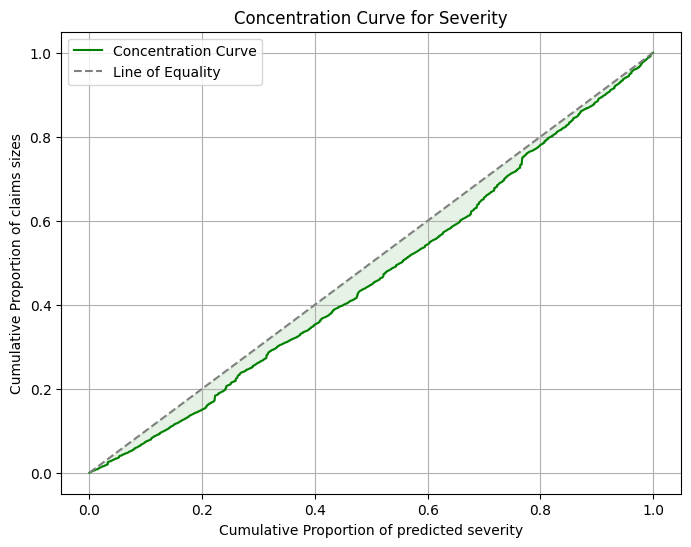

In [79]:
# Calculate concentration curve points
index = test_target_df['0'].ClaimSeverity_TRG < 37622
x_concentration, y_concentration = calculate_concentration_curve(y_true=test_target_df['0'][index].ClaimSeverity_TRG, exposure = test_predictions_df["0"][index].pure_ClaimSeverity_PRED, sample_weight=test_target_df['0'][index].ClaimNb_TRG,)

# Plot the concentration curve
plot_concentration_curve(x_concentration, y_concentration, title="Concentration Curve for Severity", marker=None)

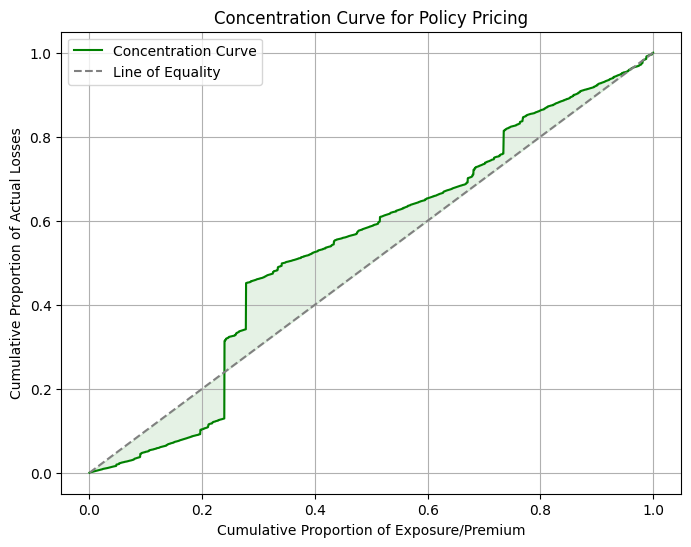

In [57]:
# Calculate concentration curve points
x_concentration, y_concentration = calculate_concentration_curve(y_true=test_target_df['0'].ClaimSeverity_TRG, exposure = test_predictions_df["0"].pure_ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG,)

# Plot the concentration curve
plot_concentration_curve(x_concentration, y_concentration, title="Concentration Curve for Policy Pricing", marker=None)

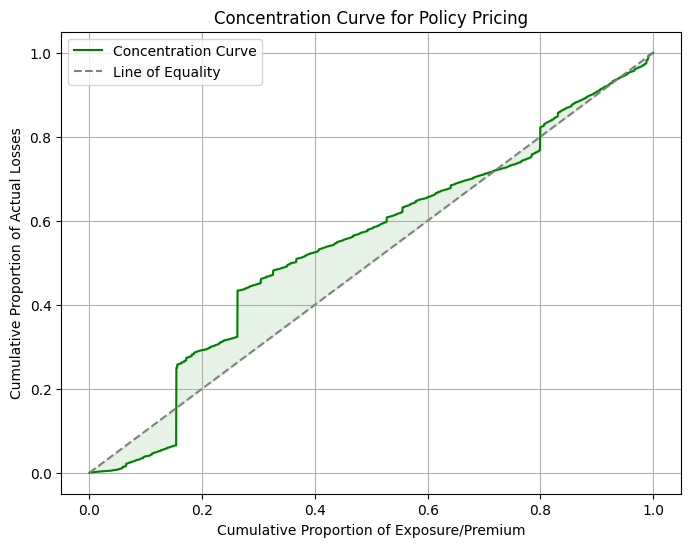

In [58]:
# Calculate concentration curve points
x_concentration, y_concentration = calculate_concentration_curve(y_true=test_target_df['0'].ClaimSeverity_TRG, exposure = test_predictions_df["0"].ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG,)

# Plot the concentration curve
plot_concentration_curve(x_concentration, y_concentration, title="Concentration Curve for Policy Pricing", marker=None)

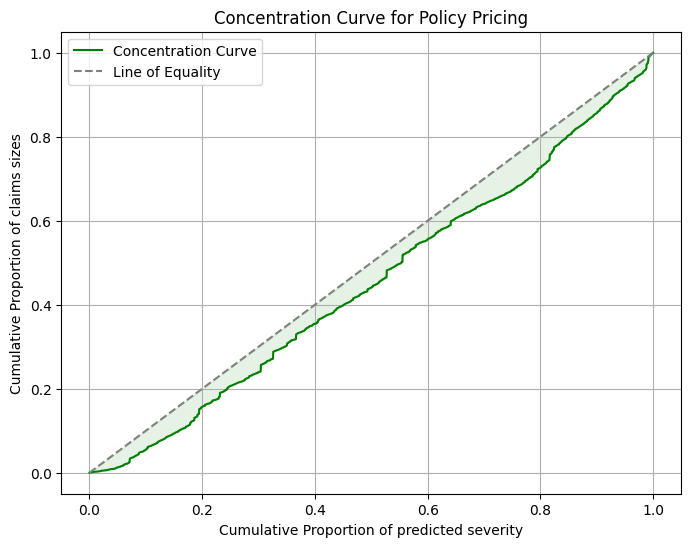

In [65]:
# Calculate concentration curve points
index = test_target_df['0'].ClaimSeverity_TRG < 100000
x_concentration, y_concentration = calculate_concentration_curve(y_true=test_target_df['0'][index].ClaimSeverity_TRG, exposure = test_predictions_df["0"][index].ClaimSeverity_PRED, sample_weight=test_target_df['0'][index].ClaimNb_TRG,)

# Plot the concentration curve
plot_concentration_curve(x_concentration, y_concentration, title="Concentration Curve for Policy Pricing", marker=None)

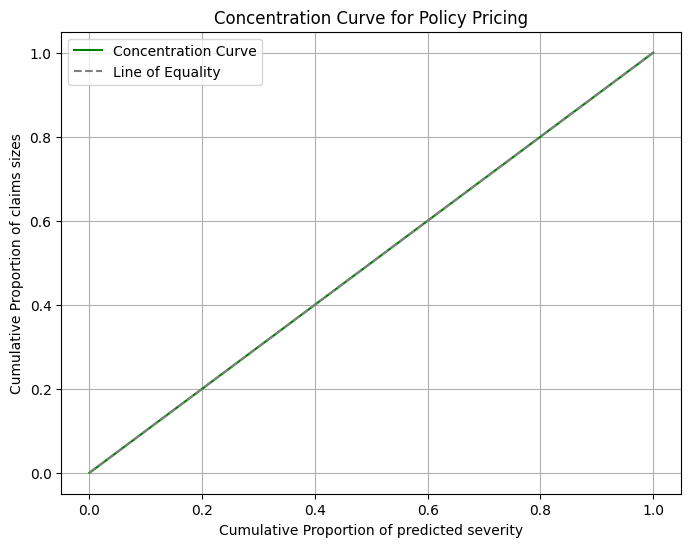

In [41]:
# Calculate concentration curve points
index = test_target_df['0'].ClaimSeverity_TRG < 100000
x_concentration, y_concentration = calculate_concentration_curve(y_true=test_target_df['0'][index].ClaimSeverity_TRG, exposure = test_target_df['0'][index].ClaimSeverity_TRG, sample_weight=test_target_df['0'][index].ClaimNb_TRG,)

# Plot the concentration curve
plot_concentration_curve(x_concentration, y_concentration, title="Concentration Curve for Policy Pricing", marker=None)

## Calibration Curve

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_calibration_curve(y_true, y_pred, sample_weight=None, n_bins=10):
    """
    Plots a calibration curve with optional sample weighting.

    Args:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.
        sample_weight (array-like, optional): Weights for each observation.
        n_bins (int): Number of bins (e.g., 10 for deciles).
    """
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'sample_weight': sample_weight if sample_weight is not None else np.ones_like(y_true)
    })

    # Bin by predicted values (quantile bins)
    df['bin'] = pd.qcut(df['y_pred'], q=n_bins, duplicates='drop')

    # Compute weighted means per bin
    def weighted_mean(x):
        return np.average(x['y_true'], weights=x['sample_weight'])

    def weighted_pred(x):
        return np.average(x['y_pred'], weights=x['sample_weight'])

    grouped = df.groupby('bin').apply(
        lambda x: pd.Series({
            'mean_y_true': weighted_mean(x),
            'mean_y_pred': weighted_pred(x)
        })
    )

    # Plot calibration curve
    plt.plot(grouped['mean_y_pred'], grouped['mean_y_true'], marker='o', label='Calibration')
    min_val = min(grouped['mean_y_pred'].min(), grouped['mean_y_true'].min())
    max_val = max(grouped['mean_y_pred'].max(), grouped['mean_y_true'].max())

    plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray', label='Perfect calibration (y = x)')
    plt.xlabel("Mean Predicted")
    plt.ylabel("Mean Actual")
    plt.title("Calibration Curve (Weighted)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [69]:
pd.qcut(test_predictions_df["0"][index].ClaimSeverity_PRED, q=10, duplicates='drop').value_counts().sort_index()

ClaimSeverity_PRED
(1297.414, 1707.189]     409
(1707.189, 1780.196]     300
(1780.196, 2049.094]     108
(2049.094, 2714.828]    1617
(2714.828, 8172.867]      57
Name: count, dtype: int64

In [75]:
len(test_predictions_df)

1

/tmp/ipykernel_7549/2839208531.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').apply(


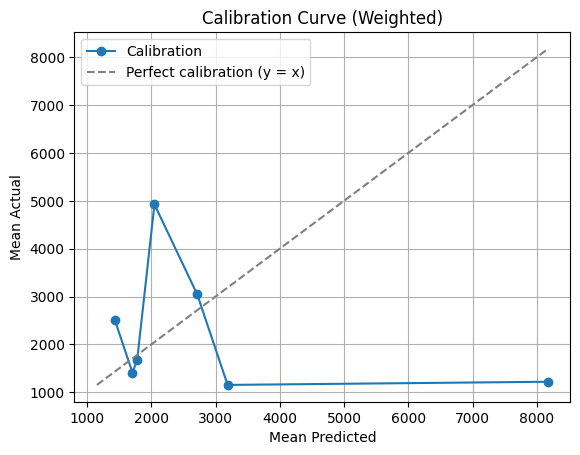

In [86]:
plot_calibration_curve(y_true=test_target_df['0'].ClaimSeverity_TRG, y_pred=test_predictions_df["0"].ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG, n_bins=100)

/tmp/ipykernel_7549/2839208531.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').apply(


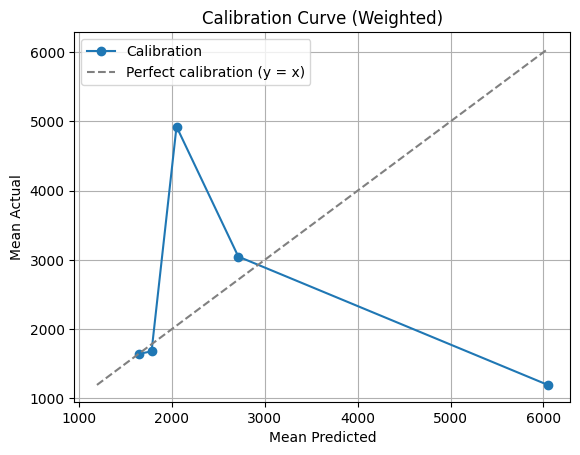

In [92]:
plot_calibration_curve(y_true=test_target_df['0'].ClaimSeverity_TRG, y_pred=test_predictions_df["0"].ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG, n_bins=10)

/tmp/ipykernel_7549/2839208531.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').apply(


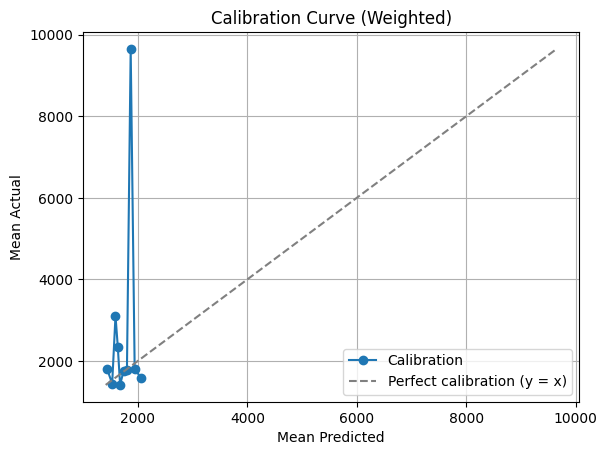

In [93]:
plot_calibration_curve(y_true=test_target_df['0'].ClaimSeverity_TRG, y_pred=test_predictions_df["0"].pure_ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG, n_bins=10)

/tmp/ipykernel_7549/2839208531.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').apply(


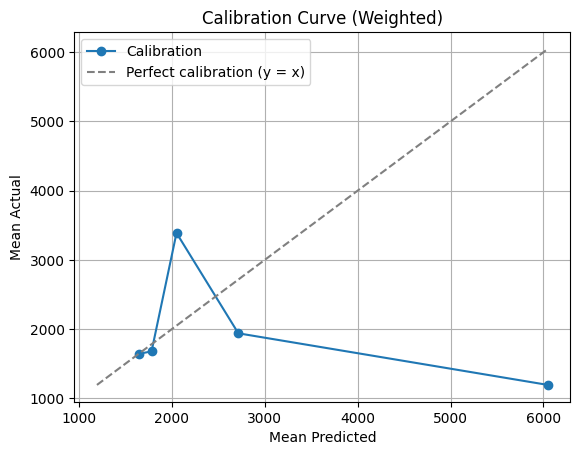

In [94]:
sv = test_target_df['0'].ClaimSeverity_TRG.copy()
sv[sv > 100000] = 100000
plot_calibration_curve(y_true=sv, y_pred=test_predictions_df["0"].ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG, n_bins=10)

In [45]:
test_predictions_df["0"][index].columns

Index(['pure_ClaimSeverity_PRED', 'calibrated_ClaimSeverity_PRED',
       'ClaimSeverity_PRED'],
      dtype='object')

## Cumulative Calibration Curve

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_cumulative_calibration(y_true, y_pred, sample_weight=None, title="Cumulative Calibration Curve"):
    """
    Plots a cumulative calibration curve with optional sample weighting.

    Args:
        y_true (array-like): Actual target values.
        y_pred (array-like): Predicted values.
        sample_weight (array-like, optional): Sample weights for each observation.
        title (str): Title of the plot.
    """
    # Convert to arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if sample_weight is None:
        sample_weight = np.ones_like(y_true)
    else:
        sample_weight = np.asarray(sample_weight)

    # Combine into DataFrame
    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "weight": sample_weight
    })

    # Sort by predicted values (ascending)
    df = df.sort_values("y_pred").reset_index(drop=True)

    # Weighted predicted and true values
    df["w_pred"] = df["y_pred"] * df["weight"]
    df["w_true"] = df["y_true"] * df["weight"]

    # Cumulative weights and values
    df["cum_weight"] = df["weight"].cumsum()
    df["cum_weight_pct"] = df["cum_weight"] / df["weight"].sum()
    df["cum_pred"] = df["w_pred"].cumsum() / df["w_pred"].sum()
    df["cum_true"] = df["w_true"].cumsum() / df["w_true"].sum()

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(df["cum_weight_pct"], df["cum_pred"], label="Cumulative Predicted", linestyle="--")
    plt.plot(df["cum_weight_pct"], df["cum_true"], label="Cumulative Actual", linestyle="-")
    plt.plot([0, 1], [0, 1], linestyle=":", color="gray", label="Ideal")
    plt.xlabel("Cumulative Proportion of Policies")
    plt.ylabel("Cumulative Proportion of Response")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


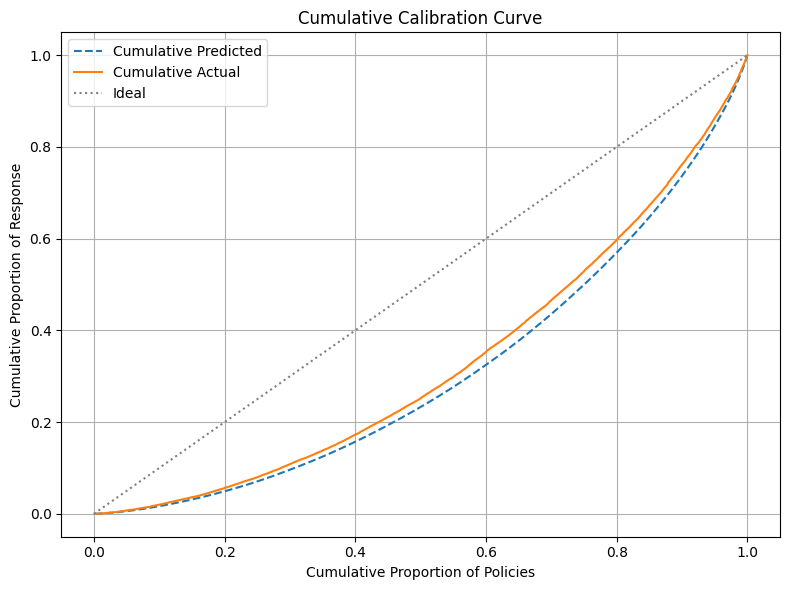

In [95]:
# Simulated data
np.random.seed(0)
y_true = np.random.gamma(shape=2, scale=100, size=1000)
y_pred = y_true * np.random.normal(loc=1.0, scale=0.2, size=1000)
weights = np.random.uniform(0.5, 2.0, size=1000)

plot_cumulative_calibration(y_true, y_pred, sample_weight=weights)

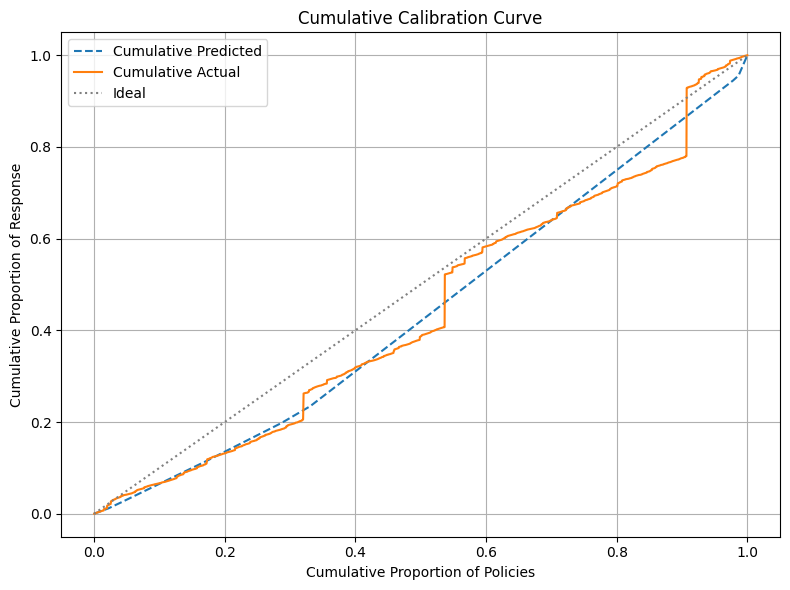

In [99]:
sv = test_target_df['0'].ClaimSeverity_TRG.copy()
sv[sv > 1000000] = 1000000
plot_cumulative_calibration(y_true=sv, y_pred=test_predictions_df["0"].ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG)

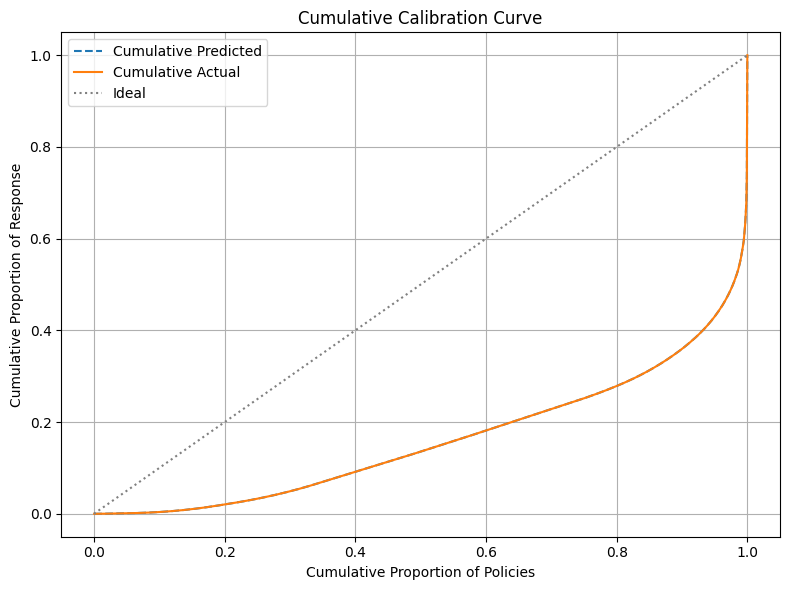

In [100]:
sv = test_target_df['0'].ClaimSeverity_TRG.copy()
sv[sv > 1000000] = 1000000
plot_cumulative_calibration(y_true=sv, y_pred=sv, sample_weight=test_target_df['0'].ClaimNb_TRG)